#  スパッタリング率のプロット

In [46]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
path2data = "/Users/y1u0d2/Downloads"
# path2data = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/sputtering"
data_filename = "sp.xlsx"
# sheet_name = "si_self_substrate_size"
sheet_name = "si_self_all_in_20240117_update"
# sheet_name = "si_self_all_in"

In [48]:
# read excel file
sy_df = pd.read_excel(os.path.join(path2data, data_filename), sheet_name=sheet_name)
sy_df.fillna(0, inplace=True)

In [49]:
# get unique combination of potential, height, and seed
unique_combination_of_potential_seed_height = sy_df.drop_duplicates(subset=["potential", "height", "seed"])[["potential", "height", "seed"]]

y
y
y
y
m
m
m
m
b
k
c
g
g
g
r
r
#f781bf
#f781bf
#a65628


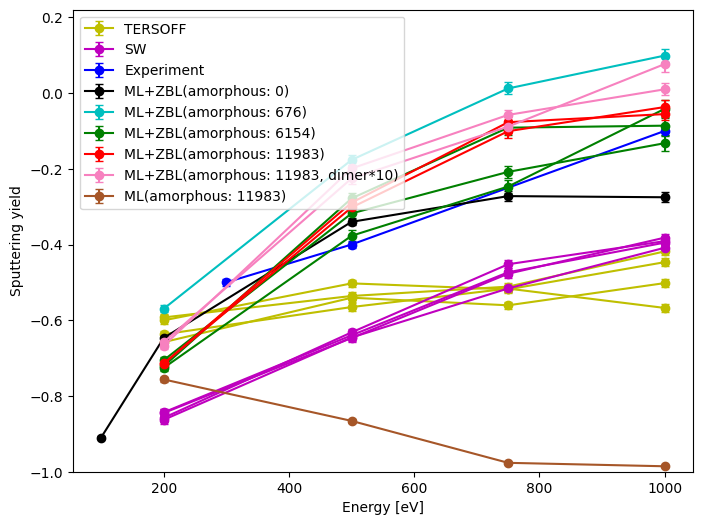

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

for unique_combination_dict in unique_combination_of_potential_seed_height.to_dict(orient="records"):
    potential = unique_combination_dict["potential"]
    height = unique_combination_dict["height"]
    seed = unique_combination_dict["seed"]

    if potential == "Experiment":
        each_potential_height_seed_df = sy_df[sy_df["potential"] == potential]
    else:
        each_potential_height_seed_df = sy_df[(sy_df["potential"] == potential) & (sy_df["height"] == height) & (sy_df["seed"] == seed)]
    print(each_potential_height_seed_df["color"].to_numpy()[0])
    ax.errorbar(
        each_potential_height_seed_df["energy"],
        each_potential_height_seed_df["sy_depo_ion_dose"],
        yerr=[
            each_potential_height_seed_df["sy_depo_ion_dose"] - each_potential_height_seed_df["lower_sy"],
            each_potential_height_seed_df["upper_sy"] - each_potential_height_seed_df["sy_depo_ion_dose"],
        ],
        capsize=3,
        marker="o",
        label=f"{potential}",
        c=each_potential_height_seed_df["color"].to_numpy()[0]
    )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.set_ylim(-1.0, 0.22)

handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list)

# 複数の線をプロットするのではなく、平均をとってプロットする

In [51]:
sy_df["potential"].unique()

array(['TERSOFF', 'SW', 'Experiment', 'ML+ZBL(amorphous: 0)',
       'ML+ZBL(amorphous: 676)', 'ML+ZBL(amorphous: 6154)',
       'ML+ZBL(amorphous: 11983)', 'ML+ZBL(amorphous: 11983, dimer*10)',
       'ML(amorphous: 11983)'], dtype=object)

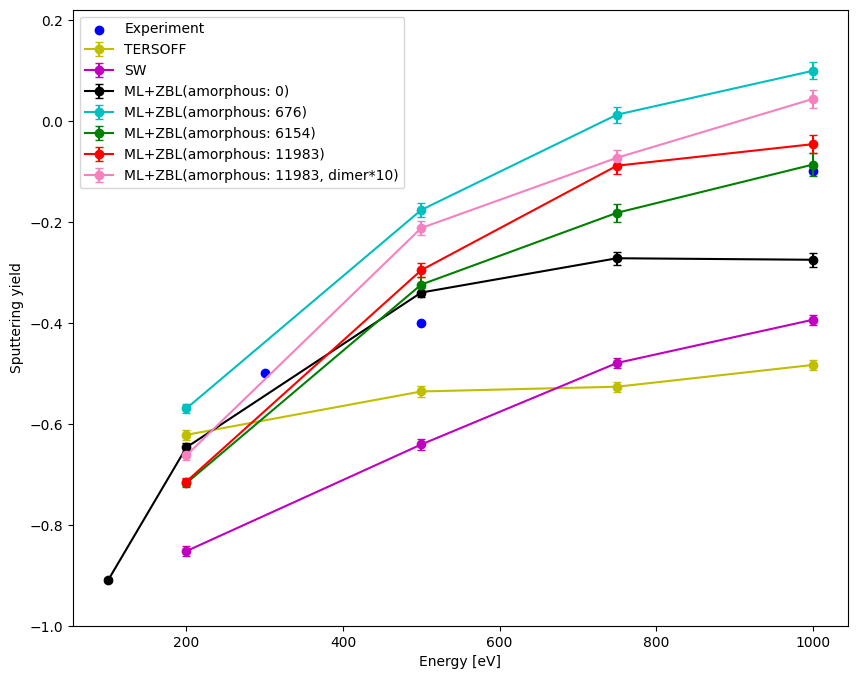

In [60]:
# potential_name_list = ['TERSOFF', 'SW', 'ML+ZBL(amorphous: 11983)']
# potential_name_list = ['TERSOFF', 'SW', 'Experiment', 'ML+ZBL(amorphous: 11983)', 'ML(amorphous: 11983)']
# potential_name_list = ['TERSOFF', 'SW', 'Experiment', 'ML+ZBL(amorphous: 0)','ML+ZBL(amorphous: 676)', 'ML+ZBL(amorphous: 6154)','ML+ZBL(amorphous: 11983)']
potential_name_list = ['TERSOFF', 'SW', 'Experiment', 'ML+ZBL(amorphous: 0)','ML+ZBL(amorphous: 676)', 'ML+ZBL(amorphous: 6154)','ML+ZBL(amorphous: 11983)', 'ML+ZBL(amorphous: 11983, dimer*10)']

# 色を指定する
potentianl_name_color_map = {}
for potential_name in potential_name_list:
    potentianl_name_color_map[potential_name] = sy_df.loc[sy_df["potential"] == potential_name, "color"].to_numpy()[0]

# スパッタリング率の平均をとってプロットする
fig, ax = plt.subplots(figsize=(10, 8))

for potential_name in potential_name_list:
    each_potential_df = sy_df[sy_df["potential"] == potential_name][["energy", "sy_depo_ion_dose", "lower_sy", "upper_sy"]]
    each_potential_df = each_potential_df.groupby(["energy"]).mean().reset_index()

    if potential_name == "ML+ZBL(amorphous: 11983)":
        # label_name = "ML+ZBL"
        label_name = potential_name
    else:
        label_name = potential_name
    
    if potential_name == "Experiment":
        ax.scatter(
            each_potential_df["energy"],
            each_potential_df["sy_depo_ion_dose"],
            marker="o",
            label=label_name,
            c=potentianl_name_color_map[potential_name]
        )
    else:
        ax.errorbar(
            each_potential_df["energy"],
            each_potential_df["sy_depo_ion_dose"],
            yerr=[
                each_potential_df["sy_depo_ion_dose"] - each_potential_df["lower_sy"],
                each_potential_df["upper_sy"] - each_potential_df["sy_depo_ion_dose"],
            ],
            capsize=3,
            marker="o",
            label=label_name,
            c=potentianl_name_color_map[potential_name]
        )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.set_ylim(-1.0, 0.22)
ax.legend()

# handles, labels = ax.get_legend_handles_labels()
# handle_list, label_list = [], []
# for handle, label in zip(handles, labels):
#     if label not in label_list:
#         handle_list.append(handle)
#         label_list.append(label)
# plt.legend(handle_list, label_list)

# Cubic splineでfittingする

In [44]:
unique_potential_name_list = sy_df["potential"].unique()

potentianl_name_color_map = {}
for potential_name in unique_potential_name_list:
    potentianl_name_color_map[potential_name] = sy_df.loc[sy_df["potential"] == potential_name, "color"].to_numpy()[0]

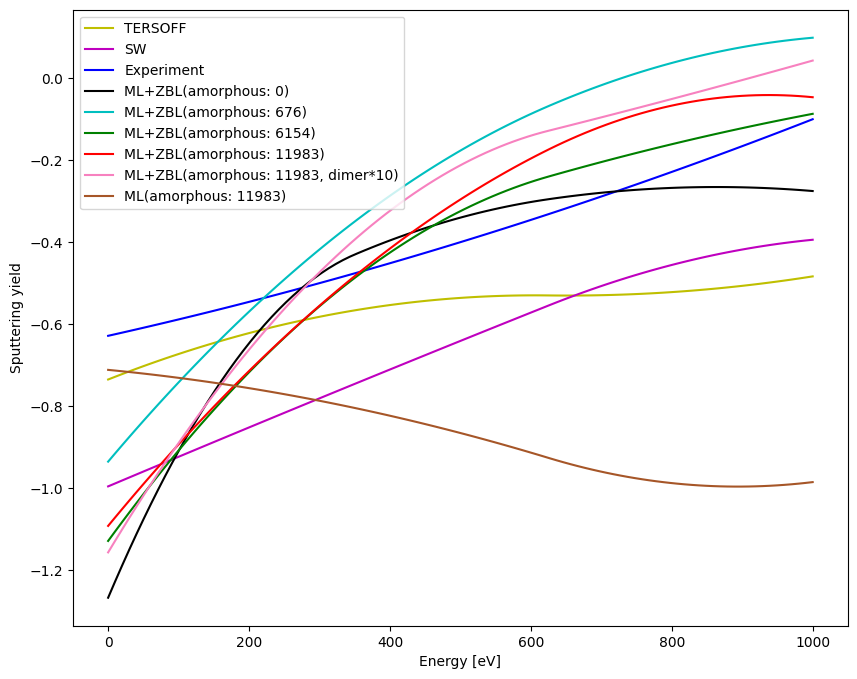

In [45]:
# Cubic splineで補間する
from scipy.interpolate import CubicSpline
from scipy.interpolate import make_interp_spline, interp1d

import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
for potential_name in unique_potential_name_list:
    each_potential_sy_df = sy_df[sy_df["potential"] == potential_name][["energy", "sy_depo_ion_dose"]].groupby(["energy"]).mean().reset_index()
    # order by energy
    each_potential_sy_df = each_potential_sy_df.sort_values(by=["energy"]).reset_index(drop=True)

    energy_list = each_potential_sy_df["energy"].to_numpy()
    sy_list = each_potential_sy_df["sy_depo_ion_dose"].to_numpy()
    # cs = CubicSpline(energy_list, sy_list)
    cs = make_interp_spline(energy_list, sy_list, k=2)

    energy_list_for_plotting = np.linspace(0, 1000, 100)
    sy_list_for_plotting = cs(energy_list_for_plotting)
    # ax.plot(energy_list, cs)
    ax.plot(energy_list_for_plotting, sy_list_for_plotting, label=potential_name, c=potentianl_name_color_map[potential_name])
    # ax.scatter(energy_list, sy_list)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")

ax.legend()

# SWだけ取り出す

m
m
m
m


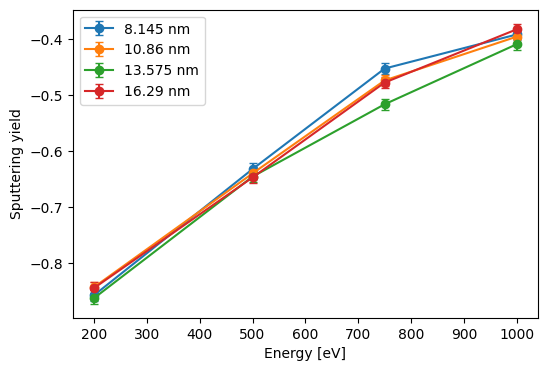

In [63]:
path2data = "/Users/y1u0d2/Downloads"
data_filename = "sp.xlsx"
sheet_name = "si_self_sw_20240117"

# read excel file
sy_df = pd.read_excel(os.path.join(path2data, data_filename), sheet_name=sheet_name)
sy_df.fillna(0, inplace=True)

unique_combination_of_potential_seed_height = sy_df.drop_duplicates(subset=["potential", "height", "seed"])[["potential", "height", "seed"]]

fig, ax = plt.subplots(figsize=(6, 4))

for unique_combination_dict in unique_combination_of_potential_seed_height.to_dict(orient="records"):
    potential = unique_combination_dict["potential"]
    height = unique_combination_dict["height"]
    seed = unique_combination_dict["seed"]

    if seed != 123456:
        continue

    if potential == "Experiment":
        each_potential_height_seed_df = sy_df[sy_df["potential"] == potential]
    else:
        each_potential_height_seed_df = sy_df[(sy_df["potential"] == potential) & (sy_df["height"] == height) & (sy_df["seed"] == seed)]
    print(each_potential_height_seed_df["color"].to_numpy()[0])
    ax.errorbar(
        each_potential_height_seed_df["energy"],
        each_potential_height_seed_df["sy_depo_ion_dose"],
        yerr=[
            each_potential_height_seed_df["sy_depo_ion_dose"] - each_potential_height_seed_df["lower_sy"],
            each_potential_height_seed_df["upper_sy"] - each_potential_height_seed_df["sy_depo_ion_dose"],
        ],
        capsize=3,
        marker="o",
        label=f"{height} nm",
        # c=each_potential_height_seed_df["color"].to_numpy()[0]
    )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
# ax.set_ylim(-1.0, 0.22)

handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list)

# Ar -> Si injection

In [64]:
from mlptools.analyzer.yamamura_tawara import YamamuraTawaraSputteringYieldCalculator
import numpy as np

yt_calculator = YamamuraTawaraSputteringYieldCalculator(projectile="Ar", target="Si")

energy_list = [50, 100, 200 ,350, 500, 750, 1000]
sp_yt = yt_calculator.get_sputtering_yield(
    energy_list=energy_list
)

In [65]:
sy_df = pd.read_excel(os.path.join(path2data, data_filename), sheet_name="argon_injection")

ar_unique_combination_of_potential_seed_height = sy_df.drop_duplicates(subset=["potential", "seed"])[["potential", "seed"]]

In [66]:
ar_unique_combination_of_potential_seed_height

,potential,seed
0,GAP,123456
4,ML+ZBL(amorphous: 676),123456
8,ML+ZBL(amorphous: 676),5455895
12,ML+ZBL(amorphous: 11983),5455895
16,ML+ZBL(amorphous: 11983),123456
20,"ML+ZBL(amorphous: 11983, dimer*10)",5455895
24,"ML+ZBL(amorphous: 11983, dimer*10)",123456
28,Zalm Expt.,123456
31,Coburn Expt.,123456
34,Wittmaack Expt.,123456


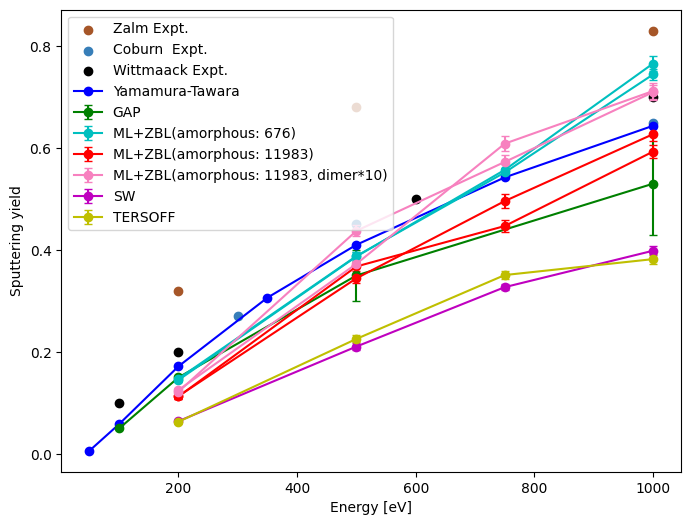

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

for unique_combination_dict in ar_unique_combination_of_potential_seed_height.to_dict(orient="records"):
    potential = unique_combination_dict["potential"]
    seed = unique_combination_dict["seed"]

    each_potential_height_seed_df = sy_df[(sy_df["potential"] == potential) & (sy_df["seed"] == seed)]
    if "Expt." in potential:
        ax.scatter(
            each_potential_height_seed_df["energy"],
            each_potential_height_seed_df["sp"],
            marker="o",
            label=f"{potential}",
            c=each_potential_height_seed_df["color"].to_numpy()[0]
        )
    else:
        ax.errorbar(
            each_potential_height_seed_df["energy"],
            each_potential_height_seed_df["sp"],
            yerr=[
                each_potential_height_seed_df["sp"] - each_potential_height_seed_df["pos_lower_bound"],
                each_potential_height_seed_df["pos_upper_bound"] - each_potential_height_seed_df["sp"],
            ],
            capsize=3,
            marker="o",
            label=f"{potential}",
            c=each_potential_height_seed_df["color"].to_numpy()[0]
        )

# plot Yamamura-Tawara model
ax.plot(
    energy_list,
    sp_yt,
    label="Yamamura-Tawara",
    marker="o",
    c="b"
)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")

handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list)

# 平均をプロットするようにする

In [68]:
sy_df["potential"].unique()

array(['GAP', 'ML+ZBL(amorphous: 676)', 'ML+ZBL(amorphous: 11983)',
       'ML+ZBL(amorphous: 11983, dimer*10)', 'Zalm Expt.',
       'Coburn  Expt.', 'Wittmaack Expt.', 'SW', 'TERSOFF'], dtype=object)

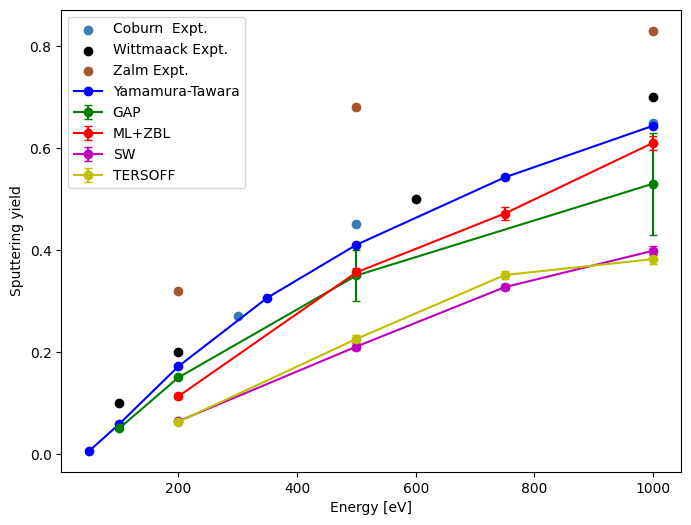

In [69]:
# potential_name_list = ['GAP', 'ML+ZBL(amorphous: 676)', 'ML+ZBL(amorphous: 11983)', 'ML+ZBL(amorphous: 11983, dimer*10)', 'Zalm Expt.', 'Coburn  Expt.', 'Wittmaack Expt.']
# potential_name_list = ['GAP', 'ML+ZBL(amorphous: 11983)', 'Zalm Expt.', 'Coburn  Expt.', 'Wittmaack Expt.']
potential_name_list = ['GAP', 'ML+ZBL(amorphous: 11983)',  'Coburn  Expt.','Wittmaack Expt.', 'Zalm Expt.', 'SW', 'TERSOFF']

potentianl_name_color_map = {}
for potential_name in potential_name_list:
    potentianl_name_color_map[potential_name] = sy_df.loc[sy_df["potential"] == potential_name, "color"].to_numpy()[0]


fig, ax = plt.subplots(figsize=(8, 6))

for potential_name in potential_name_list:
    each_potential_df = sy_df[sy_df["potential"] == potential_name][["energy", "sp", "pos_lower_bound", "pos_upper_bound"]]
    each_potential_df = each_potential_df.groupby(["energy"]).mean().reset_index()

    if "Expt." in potential_name:
        ax.scatter(
            each_potential_df["energy"],
            each_potential_df["sp"],
            marker="o",
            label=f"{potential_name}",
            c=potentianl_name_color_map[potential_name]
        )
    elif "ML+ZBL(amorphous: 11983)" in potential_name:
        ax.errorbar(
            each_potential_df["energy"],
            each_potential_df["sp"],
            yerr=[
                each_potential_df["sp"] - each_potential_df["pos_lower_bound"],
                each_potential_df["pos_upper_bound"] - each_potential_df["sp"],
            ],
            capsize=3,
            marker="o",
            label=f"ML+ZBL",
            c=potentianl_name_color_map[potential_name]
        )
    else:
        ax.errorbar(
            each_potential_df["energy"],
            each_potential_df["sp"],
            yerr=[
                each_potential_df["sp"] - each_potential_df["pos_lower_bound"],
                each_potential_df["pos_upper_bound"] - each_potential_df["sp"],
            ],
            capsize=3,
            marker="o",
            label=f"{potential_name}",
            c=potentianl_name_color_map[potential_name]
        )

# plot Yamamura-Tawara model
ax.plot(
    energy_list,
    sp_yt,
    label="Yamamura-Tawara",
    marker="o",
    c="b"
)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.legend()